# Assignment 4
## Econ 8310 - Business Forecasting

This assignment will make use of the bayesian statistical models covered in Lessons 10 to 12.

A/B Testing is a critical concept in data science, and for many companies one of the most relevant applications of data-driven decision-making. In order to improve product offerings, marketing campaigns, user interfaces, and many other user-facing interactions, scientists and engineers create experiments to determine the efficacy of proposed changes. Users are then randomly assigned to either the treatment or control group, and their behavior is recorded.
If the changes that the treatment group is exposed to can be measured to have a benefit in the metric of interest, then those changes are scaled up and rolled out to across all interactions.
Below is a short video detailing the A/B Testing process, in case you want to learn a bit more:
[https://youtu.be/DUNk4GPZ9bw](https://youtu.be/DUNk4GPZ9bw)

For this assignment, you will use an A/B test data set, which was pulled from the Kaggle website (https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing). I have added the data from the page into Codio for you. It can be found in the cookie_cats.csv file in the file tree. It can also be found at [https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv](https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv)

The variables are defined as follows:

| Variable Name  | Definition |
|----------------|----|
| userid         | A unique number that identifies each player  |
| version        | Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40) |
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install.  |
| retention1     | Did the player come back and play 1 day after installing?     |
| retention7     | Did the player come back and play 7 days after installing?    |               

### The questions

You will be asked to answer the following questions in a small quiz on Canvas:
1. What was the effect of moving the gate from level 30 to level 40 on 1-day retention rates?
2. What was the effect of moving the gate from level 30 to level 40 on 7-day retention rates?
3. What was the biggest challenge for you in completing this assignment?

You will also be asked to submit a URL to your forked GitHub repository containing your code used to answer these questions.

Dataset Details:
Total number of entries in the data: 90189
Breakdown of versions in the data:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Retention averages by version:
         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000


Output()

Output()

Output()

Output()

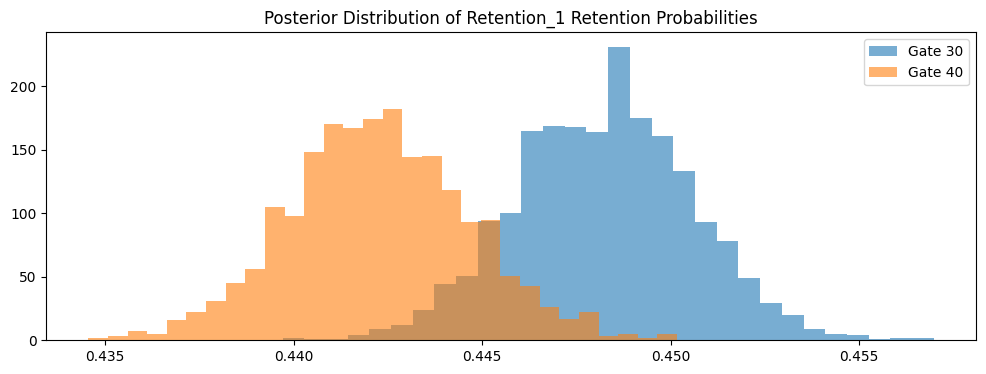

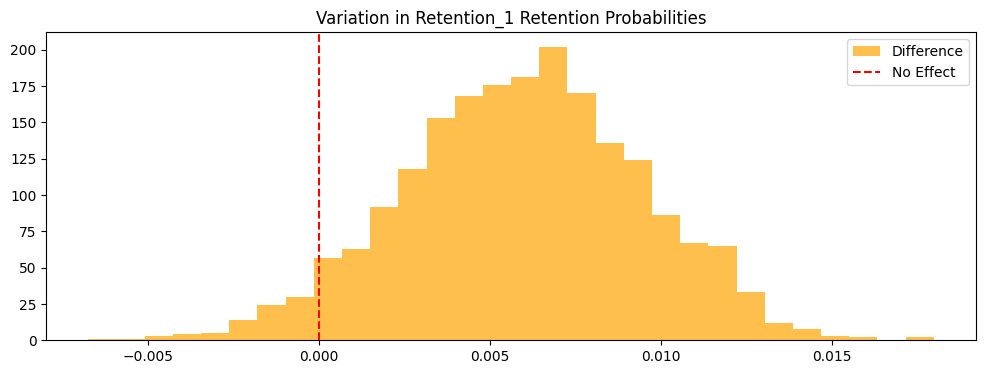


Overview of Retention_1 Retention Analysis:
                         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
p_30_retention_1        0.448  0.002     0.444      0.453        0.0      0.0   
p_40_retention_1        0.442  0.002     0.437      0.447        0.0      0.0   
difference_retention_1  0.006  0.003    -0.001      0.013        0.0      0.0   

                        ess_bulk  ess_tail  r_hat  
p_30_retention_1          1822.0    1254.0    1.0  
p_40_retention_1          1748.0    1315.0    1.0  
difference_retention_1    1786.0    1271.0    1.0  
Chance that Gate 30 exceeds Gate 40: 95.50%


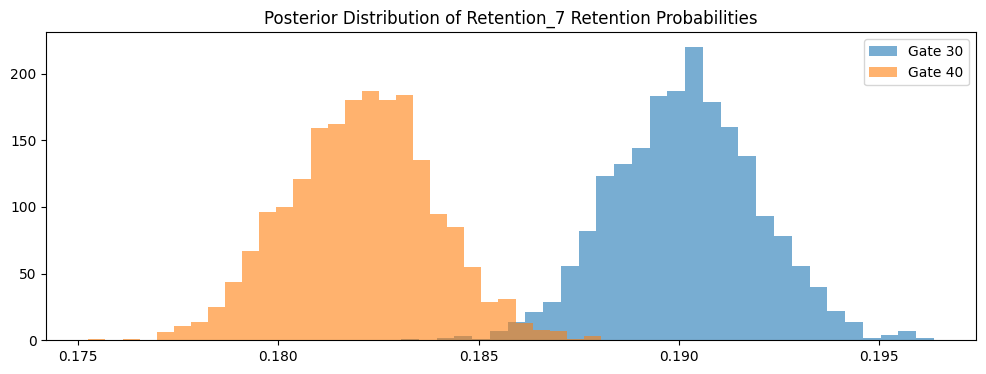

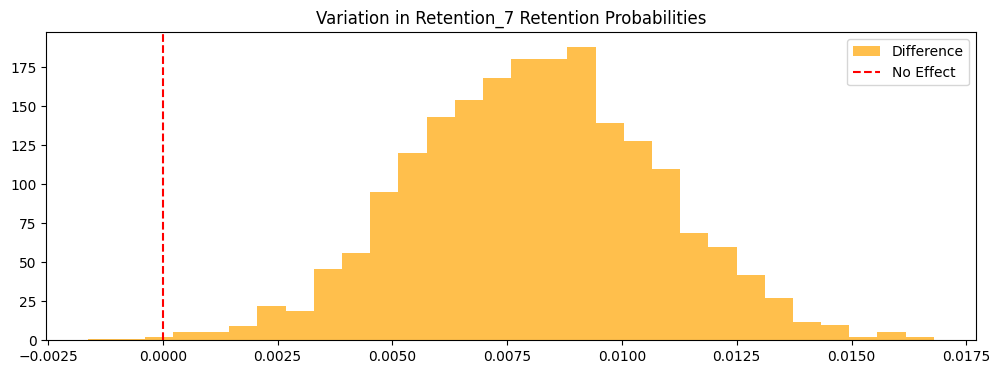


Overview of Retention_7 Retention Analysis:
                         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
p_30_retention_7        0.190  0.002     0.187      0.194        0.0      0.0   
p_40_retention_7        0.182  0.002     0.179      0.186        0.0      0.0   
difference_retention_7  0.008  0.003     0.004      0.014        0.0      0.0   

                        ess_bulk  ess_tail  r_hat  
p_30_retention_7          1870.0    1522.0    1.0  
p_40_retention_7          2061.0    1545.0    1.0  
difference_retention_7    1957.0    1327.0    1.0  
Chance that Gate 30 exceeds Gate 40: 99.85%


In [4]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

def fetch_data(file_path):
    """Fetches the dataset from the given file path."""
    return pd.read_csv(file_path)

def display_data_overview(data):
    """Displays a summary of the dataset."""
    print("Dataset Details:")
    print("=" * 50)
    print(f"Total number of entries in the data: {len(data)}")
    print(f"Breakdown of versions in the data:\n{data['version'].value_counts()}")
    retention_summary = data.groupby('version')[['retention_1', 'retention_7']].mean()
    print("\nRetention averages by version:")
    print(retention_summary)

def run_bayesian_model(gate_30_retention, gate_40_retention, retention_type):
    """Performs Bayesian analysis using a Beta-Bernoulli model."""
    with pm.Model() as model:
        p_30 = pm.Beta(f'p_30_{retention_type}', alpha=1, beta=1)
        p_40 = pm.Beta(f'p_40_{retention_type}', alpha=1, beta=1)

        pm.Bernoulli(f'obs_30_{retention_type}', p=p_30, observed=gate_30_retention)
        pm.Bernoulli(f'obs_40_{retention_type}', p=p_40, observed=gate_40_retention)

        difference = pm.Deterministic(f'difference_{retention_type}', p_30 - p_40)

        trace = pm.sample(1000, tune=1000, chains=2, random_seed=42)

    return trace, difference

def analyze_retention(data, retention_types):
    """Analyzes retention data using Bayesian methods."""
    traces = {}

    for retention_type in retention_types:
        gate_30_retention = data[data['version'] == 'gate_30'][retention_type]
        gate_40_retention = data[data['version'] == 'gate_40'][retention_type]

        trace, difference = run_bayesian_model(gate_30_retention, gate_40_retention, retention_type)
        traces[retention_type] = (trace, difference)

    return traces

def plot_results(traces, retention_types):
    """Plots posterior distributions and differences for each retention type."""
    for retention_type in retention_types:
        trace, difference = traces[retention_type]

        # Extract samples from the trace directly
        p_30_samples = trace.posterior[f'p_30_{retention_type}'].values.flatten()
        p_40_samples = trace.posterior[f'p_40_{retention_type}'].values.flatten()

        # Access the difference sample using the trace's posterior
        difference_samples = trace.posterior[f'difference_{retention_type}'].values.flatten()

        # Plot the posterior distribution for Gate 30 and Gate 40
        plt.figure(figsize=(12, 4))
        plt.hist(p_30_samples, bins=30, alpha=0.6, label='Gate 30')
        plt.hist(p_40_samples, bins=30, alpha=0.6, label='Gate 40')
        plt.title(f'Posterior Distribution of {retention_type.capitalize()} Retention Probabilities')
        plt.legend()
        plt.show()

        # Plot the difference distribution
        plt.figure(figsize=(12, 4))
        plt.hist(difference_samples, bins=30, alpha=0.7, label='Difference', color='orange')
        plt.axvline(0, color='red', linestyle='--', label='No Effect')
        plt.title(f'Variation in {retention_type.capitalize()} Retention Probabilities')
        plt.legend()
        plt.show()

        print(f"\nOverview of {retention_type.capitalize()} Retention Analysis:")
        print("=" * 50)
        print(az.summary(trace, var_names=[f'p_30_{retention_type}', f'p_40_{retention_type}', f'difference_{retention_type}'], hdi_prob=0.95))

        prob_superior = np.mean(difference_samples > 0)
        print(f"Chance that Gate 30 exceeds Gate 40: {prob_superior:.2%}")

def main(file_path):
    data = fetch_data(file_path)
    display_data_overview(data)
    retention_types = ['retention_1', 'retention_7']
    traces = analyze_retention(data, retention_types)
    plot_results(traces, retention_types)

if __name__ == "__main__":
    file_path = "https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv"
    main(file_path)
